In [ ]:
#| default_exp models.nhits

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

# NHITS

Long-horizon forecasting is challenging because of the *volatility* of the predictions and the *computational complexity*. To solve this problem we created the Neural Hierarchical Interpolation for Time Series (NHITS). `NHITS` builds upon `NBEATS` and specializes its partial outputs in the different frequencies of the time series through hierarchical interpolation and multi-rate input
processing. On the long-horizon forecasting task `NHITS` improved accuracy by 25% on AAAI's best paper award the `Informer`, while being 50x faster.

The model is composed of several MLPs with ReLU non-linearities. Blocks are connected via doubly residual stacking principle with the backcast $\mathbf{\tilde{y}}_{t-L:t,l}$ and forecast $\mathbf{\hat{y}}_{t+1:t+H,l}$ outputs of the l-th block. Multi-rate input pooling, hierarchical interpolation and backcast residual connections together induce the specialization of the additive predictions in different signal bands, reducing memory footprint and computational time, thus improving the architecture parsimony and accuracy.

**References**<br>
-[Boris N. Oreshkin, Dmitri Carpov, Nicolas Chapados, Yoshua Bengio (2019). "N-BEATS: Neural basis expansion analysis for interpretable time series forecasting".](https://arxiv.org/abs/1905.10437)<br>
-[Cristian Challu, Kin G. Olivares, Boris N. Oreshkin, Federico Garza, Max Mergenthaler-Canseco, Artur Dubrawski (2023). "NHITS: Neural Hierarchical Interpolation for Time Series Forecasting". Accepted at the Thirty-Seventh AAAI Conference on Artificial Intelligence.](https://arxiv.org/abs/2201.12886)<br>
-[Zhou, H.; Zhang, S.; Peng, J.; Zhang, S.; Li, J.; Xiong, H.; and Zhang, W. (2020). "Informer: Beyond Efficient Transformer for Long Sequence Time-Series Forecasting". Association for the Advancement of Artificial Intelligence Conference 2021 (AAAI 2021).](https://arxiv.org/abs/2012.07436)

![Figure 1. Neural Hierarchical Interpolation for Time Series (NHITS).](imgs_models/nhits.png)

In [ ]:
#| hide
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [ ]:
#| export
from typing import Tuple, Optional

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from neuralforecast.losses.pytorch import MAE
from neuralforecast.common._base_windows import BaseWindows

In [ ]:
#| hide
from fastcore.test import test_eq
from nbdev.showdoc import show_doc
from neuralforecast.utils import generate_series

In [ ]:
#| hide
import logging
import warnings

logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

#plt.rcParams["axes.grid"]=True
plt.rcParams['font.family'] = 'serif'
#plt.rcParams["figure.figsize"] = (4,2)

In [ ]:
#| export
class _IdentityBasis(nn.Module):
    def __init__(self, backcast_size: int, forecast_size: int,
                 interpolation_mode: str, out_features: int=1):
        super().__init__()
        assert (interpolation_mode in ['linear','nearest']) or ('cubic' in interpolation_mode)
        self.forecast_size = forecast_size
        self.backcast_size = backcast_size
        self.interpolation_mode = interpolation_mode
        self.out_features = out_features

    def forward(self, theta: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:

        backcast = theta[:, :self.backcast_size]
        knots = theta[:, self.backcast_size:]

        # Interpolation is performed on default dim=-1 := H
        knots = knots.reshape(len(knots), self.out_features, -1)
        if self.interpolation_mode in ['nearest', 'linear']:
            #knots = knots[:,None,:]
            forecast = F.interpolate(knots, size=self.forecast_size, mode=self.interpolation_mode)
            #forecast = forecast[:,0,:]
        elif 'cubic' in self.interpolation_mode:
            if self.out_features>1:
                raise Exception('Cubic interpolation not available with multiple outputs.')
            batch_size = len(backcast)
            knots = knots[:,None,:,:]
            forecast = torch.zeros((len(knots), self.forecast_size)).to(knots.device)
            n_batches = int(np.ceil(len(knots)/batch_size))
            for i in range(n_batches):
                forecast_i = F.interpolate(knots[i*batch_size:(i+1)*batch_size],
                                           size=self.forecast_size, mode='bicubic')
                forecast[i*batch_size:(i+1)*batch_size] += forecast_i[:,0,0,:] # [B,None,H,H] -> [B,H]
            forecast = forecast[:,None,:] # [B,H] -> [B,None,H]

        # [B,Q,H] -> [B,H,Q]
        forecast = forecast.permute(0, 2, 1)
        return backcast, forecast

In [ ]:
#| exporti
ACTIVATIONS = ['ReLU',
               'Softplus',
               'Tanh',
               'SELU',
               'LeakyReLU',
               'PReLU',
               'Sigmoid']

POOLING = ['MaxPool1d',
           'AvgPool1d']

class NHITSBlock(nn.Module):
    """
    NHITS block which takes a basis function as an argument.
    """
    def __init__(self,
                 input_size: int,
                 h: int,
                 n_theta: int,
                 mlp_units: list,
                 basis: nn.Module,
                 futr_input_size: int,
                 hist_input_size: int,
                 stat_input_size: int,
                 n_pool_kernel_size: int,
                 pooling_mode: str,
                 dropout_prob: float,
                 activation: str):
        super().__init__()

        pooled_hist_size = int(np.ceil(input_size/n_pool_kernel_size))
        pooled_futr_size = int(np.ceil((input_size+h)/n_pool_kernel_size))

        input_size = pooled_hist_size + \
                     hist_input_size * pooled_hist_size + \
                     futr_input_size * pooled_futr_size + stat_input_size

        self.dropout_prob = dropout_prob
        self.futr_input_size = futr_input_size
        self.hist_input_size = hist_input_size
        self.stat_input_size = stat_input_size

        assert activation in ACTIVATIONS, f'{activation} is not in {ACTIVATIONS}'
        assert pooling_mode in POOLING, f'{pooling_mode} is not in {POOLING}'

        activ = getattr(nn, activation)()

        self.pooling_layer = getattr(nn, pooling_mode)(kernel_size=n_pool_kernel_size,
                                                       stride=n_pool_kernel_size, ceil_mode=True)

        # Block MLPs
        hidden_layers = [nn.Linear(in_features=input_size,
                                   out_features=mlp_units[0][0])]
        for layer in mlp_units:
            hidden_layers.append(nn.Linear(in_features=layer[0],
                                           out_features=layer[1]))
            hidden_layers.append(activ)

            if self.dropout_prob>0:
                #raise NotImplementedError('dropout')
                hidden_layers.append(nn.Dropout(p=self.dropout_prob))

        output_layer = [nn.Linear(in_features=mlp_units[-1][1], out_features=n_theta)]
        layers = hidden_layers + output_layer
        self.layers = nn.Sequential(*layers)
        self.basis = basis

    def forward(self, insample_y: torch.Tensor, futr_exog: torch.Tensor,
                hist_exog: torch.Tensor, stat_exog: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:

        # Pooling
        # Pool1d needs 3D input, (B,C,L), adding C dimension
        insample_y = insample_y.unsqueeze(1)
        insample_y = self.pooling_layer(insample_y)
        insample_y = insample_y.squeeze(1)

        # Flatten MLP inputs [B, L+H, C] -> [B, (L+H)*C]
        # Contatenate [ Y_t, | X_{t-L},..., X_{t} | F_{t-L},..., F_{t+H} | S ]
        batch_size = len(insample_y)
        if self.hist_input_size > 0:
            hist_exog = hist_exog.permute(0,2,1) # [B, L, C] -> [B, C, L]
            hist_exog = self.pooling_layer(hist_exog)
            hist_exog = hist_exog.permute(0,2,1) # [B, C, L] -> [B, L, C]
            insample_y = torch.cat(( insample_y, hist_exog.reshape(batch_size,-1) ), dim=1)

        if self.futr_input_size > 0:
            futr_exog = futr_exog.permute(0,2,1) # [B, L, C] -> [B, C, L]
            futr_exog = self.pooling_layer(futr_exog)
            futr_exog = futr_exog.permute(0,2,1) # [B, C, L] -> [B, L, C]
            insample_y = torch.cat(( insample_y, futr_exog.reshape(batch_size,-1) ), dim=1)

        if self.stat_input_size > 0:
            insample_y = torch.cat(( insample_y, stat_exog.reshape(batch_size,-1) ), dim=1)

        # Compute local projection weights and projection
        theta = self.layers(insample_y)
        backcast, forecast = self.basis(theta)
        return backcast, forecast

In [ ]:
#| export
class NHITS(BaseWindows):
    """ NHITS

    The Neural Hierarchical Interpolation for Time Series (NHITS), is an MLP-based deep
    neural architecture with backward and forward residual links. NHITS tackles volatility and
    memory complexity challenges, by locally specializing its sequential predictions into
    the signals frequencies with hierarchical interpolation and pooling.

    **Parameters:**<br>
    `h`: int, Forecast horizon. <br>
    `input_size`: int, autorregresive inputs size, y=[1,2,3,4] input_size=2 -> y_[t-2:t]=[1,2].<br>
    `stat_exog_list`: str list, static exogenous columns.<br>
    `hist_exog_list`: str list, historic exogenous columns.<br>
    `futr_exog_list`: str list, future exogenous columns.<br>
    `exclude_insample_y`: bool=False, the model skips the autoregressive features y[t-input_size:t] if True.<br>
    `activation`: str, activation from ['ReLU', 'Softplus', 'Tanh', 'SELU', 'LeakyReLU', 'PReLU', 'Sigmoid'].<br>
    `stack_types`: List[str], stacks list in the form N * ['identity'], to be deprecated in favor of `n_stacks`. Note that len(stack_types)=len(n_freq_downsample)=len(n_pool_kernel_size).<br>
    `n_blocks`: List[int], Number of blocks for each stack. Note that len(n_blocks) = len(stack_types).<br>
    `mlp_units`: List[List[int]], Structure of hidden layers for each stack type. Each internal list should contain the number of units of each hidden layer. Note that len(n_hidden) = len(stack_types).<br>
    `n_freq_downsample`: List[int], list with the stack's coefficients (inverse expressivity ratios). Note that len(stack_types)=len(n_freq_downsample)=len(n_pool_kernel_size).<br>
    `interpolation_mode`: str='linear', interpolation basis from ['linear', 'nearest', 'cubic'].<br>
    `n_pool_kernel_size`: List[int], list with the size of the windows to take a max/avg over. Note that len(stack_types)=len(n_freq_downsample)=len(n_pool_kernel_size).<br>
    `pooling_mode`: str, input pooling module from ['MaxPool1d', 'AvgPool1d'].<br>
    `dropout_prob_theta`: float, Float between (0, 1). Dropout for NHITS basis.<br>
    `loss`: PyTorch module, instantiated train loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
    `valid_loss`: PyTorch module=`loss`, instantiated valid loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
    `max_steps`: int=1000, maximum number of training steps.<br>
    `learning_rate`: float=1e-3, Learning rate between (0, 1).<br>
    `num_lr_decays`: int=-1, Number of learning rate decays, evenly distributed across max_steps.<br>
    `early_stop_patience_steps`: int=-1, Number of validation iterations before early stopping.<br>
    `val_check_steps`: int=100, Number of training steps between every validation loss check.<br>
    `batch_size`: int=32, number of different series in each batch.<br>
    `valid_batch_size`: int=None, number of different series in each validation and test batch, if None uses batch_size.<br>
    `windows_batch_size`: int=1024, number of windows to sample in each training batch, default uses all.<br>
    `inference_windows_batch_size`: int=-1, number of windows to sample in each inference batch, -1 uses all.<br>
    `start_padding_enabled`: bool=False, if True, the model will pad the time series with zeros at the beginning, by input size.<br>
    `step_size`: int=1, step size between each window of temporal data.<br>
    `scaler_type`: str='identity', type of scaler for temporal inputs normalization see [temporal scalers](https://nixtla.github.io/neuralforecast/common.scalers.html).<br>
    `random_seed`: int, random_seed for pytorch initializer and numpy generators.<br>
    `num_workers_loader`: int=os.cpu_count(), workers to be used by `TimeSeriesDataLoader`.<br>
    `drop_last_loader`: bool=False, if True `TimeSeriesDataLoader` drops last non-full batch.<br>
    `alias`: str, optional,  Custom name of the model.<br>
    `**trainer_kwargs`: int,  keyword trainer arguments inherited from [PyTorch Lighning's trainer](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).<br>

    **References:**<br>
    -[Cristian Challu, Kin G. Olivares, Boris N. Oreshkin, Federico Garza,
    Max Mergenthaler-Canseco, Artur Dubrawski (2023). "NHITS: Neural Hierarchical Interpolation for Time Series Forecasting".
    Accepted at the Thirty-Seventh AAAI Conference on Artificial Intelligence.](https://arxiv.org/abs/2201.12886)
    """
    # Class attributes
    SAMPLING_TYPE = 'windows'

    def __init__(self,
                 h,
                 input_size,
                 futr_exog_list = None,
                 hist_exog_list = None,
                 stat_exog_list = None,
                 exclude_insample_y = False,
                 stack_types: list = ['identity', 'identity', 'identity'],
                 n_blocks: list = [1, 1, 1],
                 mlp_units: list = 3 * [[512, 512]],
                 n_pool_kernel_size: list = [2, 2, 1],
                 n_freq_downsample: list = [4, 2, 1],
                 pooling_mode: str = 'MaxPool1d',
                 interpolation_mode: str = 'linear',
                 dropout_prob_theta = 0.,
                 activation = 'ReLU',
                 loss = MAE(),
                 valid_loss = None,
                 max_steps: int = 1000,
                 learning_rate: float = 1e-3,
                 num_lr_decays: int = 3,
                 early_stop_patience_steps: int =-1,
                 val_check_steps: int = 100,
                 batch_size: int = 32,
                 valid_batch_size: Optional[int] = None,
                 windows_batch_size: int = 1024,
                 inference_windows_batch_size: int = -1,
                 start_padding_enabled = False,
                 step_size: int = 1,
                 scaler_type: str = 'identity',
                 random_seed: int = 1,
                 num_workers_loader = 0,
                 drop_last_loader = False,
                 **trainer_kwargs):

        # Inherit BaseWindows class
        super(NHITS, self).__init__(h=h,
                                    input_size=input_size,
                                    futr_exog_list=futr_exog_list,
                                    hist_exog_list=hist_exog_list,
                                    stat_exog_list=stat_exog_list,
                                    exclude_insample_y = exclude_insample_y,
                                    loss=loss,
                                    valid_loss=valid_loss,
                                    max_steps=max_steps,
                                    learning_rate=learning_rate,
                                    num_lr_decays=num_lr_decays,
                                    early_stop_patience_steps=early_stop_patience_steps,
                                    val_check_steps=val_check_steps,
                                    batch_size=batch_size,
                                    windows_batch_size=windows_batch_size,
                                    valid_batch_size=valid_batch_size,
                                    inference_windows_batch_size=inference_windows_batch_size,
                                    start_padding_enabled=start_padding_enabled,
                                    step_size=step_size,
                                    scaler_type=scaler_type,
                                    num_workers_loader=num_workers_loader,
                                    drop_last_loader=drop_last_loader,
                                    random_seed=random_seed,
                                    **trainer_kwargs)

        # Architecture
        self.futr_input_size = len(self.futr_exog_list)
        self.hist_input_size = len(self.hist_exog_list)
        self.stat_input_size = len(self.stat_exog_list)

        blocks = self.create_stack(h=h,
                                   input_size=input_size,
                                   stack_types=stack_types,
                                   futr_input_size=self.futr_input_size,
                                   hist_input_size=self.hist_input_size,
                                   stat_input_size=self.stat_input_size,
                                   n_blocks=n_blocks,
                                   mlp_units=mlp_units,
                                   n_pool_kernel_size=n_pool_kernel_size,
                                   n_freq_downsample=n_freq_downsample,
                                   pooling_mode=pooling_mode,
                                   interpolation_mode=interpolation_mode,
                                   dropout_prob_theta=dropout_prob_theta,
                                   activation=activation)
        self.blocks = torch.nn.ModuleList(blocks)

    def create_stack(self,
                     h,
                     input_size,
                     stack_types,
                     n_blocks,
                     mlp_units,
                     n_pool_kernel_size,
                     n_freq_downsample,
                     pooling_mode,
                     interpolation_mode,
                     dropout_prob_theta,
                     activation,
                     futr_input_size, hist_input_size, stat_input_size):

        block_list = []
        for i in range(len(stack_types)):
            for block_id in range(n_blocks[i]):

                assert stack_types[i] == 'identity', f'Block type {stack_types[i]} not found!'

                n_theta = (input_size + self.loss.outputsize_multiplier*max(h//n_freq_downsample[i], 1) )
                basis = _IdentityBasis(backcast_size=input_size, forecast_size=h,
                                       out_features=self.loss.outputsize_multiplier,
                                       interpolation_mode=interpolation_mode)

                nbeats_block = NHITSBlock(h=h,
                                          input_size=input_size,
                                          futr_input_size=futr_input_size,
                                          hist_input_size=hist_input_size,
                                          stat_input_size=stat_input_size,
                                          n_theta=n_theta,
                                          mlp_units=mlp_units,
                                          n_pool_kernel_size=n_pool_kernel_size[i],
                                          pooling_mode=pooling_mode,
                                          basis=basis,
                                          dropout_prob=dropout_prob_theta,
                                          activation=activation)

                # Select type of evaluation and apply it to all layers of block
                block_list.append(nbeats_block)

        return block_list

    def forward(self, windows_batch):

        # Parse windows_batch
        insample_y    = windows_batch['insample_y']
        insample_mask = windows_batch['insample_mask']
        futr_exog     = windows_batch['futr_exog']
        hist_exog     = windows_batch['hist_exog']
        stat_exog     = windows_batch['stat_exog']

        # insample
        residuals = insample_y.flip(dims=(-1,)) #backcast init
        insample_mask = insample_mask.flip(dims=(-1,))

        forecast = insample_y[:, -1:, None] # Level with Naive1
        block_forecasts = [ forecast.repeat(1, self.h, 1) ]
        for i, block in enumerate(self.blocks):
            backcast, block_forecast = block(insample_y=residuals, futr_exog=futr_exog,
                                             hist_exog=hist_exog, stat_exog=stat_exog)
            residuals = (residuals - backcast) * insample_mask
            forecast = forecast + block_forecast

            if self.decompose_forecast:
                block_forecasts.append(block_forecast)

        # Adapting output's domain
        forecast = self.loss.domain_map(forecast)

        if self.decompose_forecast:
            # (n_batch, n_blocks, h, output_size)
            block_forecasts = torch.stack(block_forecasts)
            block_forecasts = block_forecasts.permute(1,0,2,3)
            block_forecasts = block_forecasts.squeeze(-1) # univariate output
            return block_forecasts
        else:
            return forecast

In [ ]:
show_doc(NHITS)

In [ ]:
show_doc(NHITS.fit, name='NHITS.fit')

In [ ]:
show_doc(NHITS.predict, name='NHITS.predict')

In [ ]:
#| hide
import logging
import warnings
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

In [ ]:
#| hide
import pandas as pd
import matplotlib.pyplot as plt

import pytorch_lightning as pl

from neuralforecast.utils import AirPassengersDF as Y_df
from neuralforecast.tsdataset import TimeSeriesDataset, TimeSeriesLoader

Y_train_df = Y_df[Y_df.ds<Y_df['ds'].values[-24]] # 132 train
Y_test_df = Y_df[Y_df.ds>=Y_df['ds'].values[-24]] # 12 test

dataset, *_ = TimeSeriesDataset.from_df(df = Y_train_df)
model = NHITS(h=24,
              input_size=24*2,
              max_steps=1,
              windows_batch_size=None,
              n_freq_downsample=[12,4,1],
              pooling_mode='MaxPool1d')
model.fit(dataset=dataset)
y_hat = model.predict(dataset=dataset)
Y_test_df['NHITS'] = y_hat

pd.concat([Y_train_df, Y_test_df]).drop('unique_id', axis=1).set_index('ds').plot()

In [ ]:
#| hide
# qualitative decomposition evaluation
y_hat = model.decompose(dataset=dataset)

fig, ax = plt.subplots(5, 1, figsize=(10, 15))

ax[0].plot(Y_test_df['y'].values, label='True', color="#9C9DB2", linewidth=4)
ax[0].plot(y_hat.sum(axis=1).flatten(), label='Forecast', color="#7B3841")
ax[0].legend(prop={'size': 20})
for label in (ax[0].get_xticklabels() + ax[0].get_yticklabels()):
    label.set_fontsize(18)
ax[0].set_ylabel('y', fontsize=20)

ax[1].plot(y_hat[0,0], label='level', color="#7B3841")
ax[1].set_ylabel('Level', fontsize=20)

ax[2].plot(y_hat[0,1], label='stack1', color="#7B3841")
ax[2].set_ylabel('Stack 1', fontsize=20)

ax[3].plot(y_hat[0,2], label='stack2', color="#D9AE9E")
ax[3].set_ylabel('Stack 2', fontsize=20)

ax[4].plot(y_hat[0,3], label='stack3', color="#D9AE9E")
ax[4].set_ylabel('Stack 3', fontsize=20)

ax[4].set_xlabel('Prediction \u03C4 \u2208 {t+1,..., t+H}', fontsize=20)

## Usage Example

In [ ]:
!pip install pytorch-lightning
!pip install neuralforecast

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.6/774.6 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 54.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.6/170.6 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 42.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.5 MB/s eta 0:00:00


INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[]

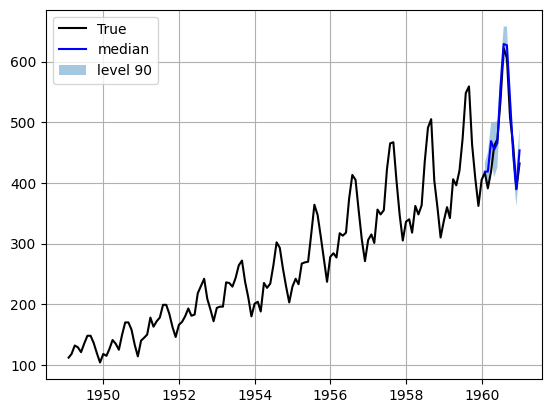

In [ ]:
#| eval: false
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.models import NHITS
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss, PMM, GMM, NBMM
from neuralforecast.tsdataset import TimeSeriesDataset
from neuralforecast.utils import AirPassengers, AirPassengersPanel, AirPassengersStatic


Y_train_df = AirPassengersPanel[AirPassengersPanel.ds<AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 132 train
Y_test_df = AirPassengersPanel[AirPassengersPanel.ds>=AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 12 test

model = NHITS(h=12,
              input_size=24,
              loss=DistributionLoss(distribution='StudentT', level=[80, 90], return_params=True),
              #loss=DistributionLoss(distribution='Normal', level=[80, 90], return_params=True),
              #loss=DistributionLoss(distribution='Poisson', level=[80, 90], return_params=True),
              #loss=DistributionLoss(distribution='Tweedie', level=[80, 90], rho=1.5),
              #loss=DistributionLoss(distribution='NegativeBinomial', level=[80, 90], return_params=True),
              #loss=NBMM(n_components=2, level=[80,90]),
              #loss=GMM(n_components=2, level=[80,90]),
              #loss=PMM(n_components=1, level=[80,90]),
              stat_exog_list=['airline1'],
              futr_exog_list=['trend'],
              n_freq_downsample=[2, 1, 1],
              scaler_type='robust',
              max_steps=200,
              early_stop_patience_steps=2,
              inference_windows_batch_size=1,
              val_check_steps=10,
              learning_rate=1e-3)

fcst = NeuralForecast(models=[model], freq='M')
fcst.fit(df=Y_train_df, static_df=AirPassengersStatic, val_size=12)
forecasts = fcst.predict(futr_df=Y_test_df)

# Plot quantile predictions
Y_hat_df = forecasts.reset_index(drop=False).drop(columns=['unique_id','ds'])
plot_df = pd.concat([Y_test_df, Y_hat_df], axis=1)
plot_df = pd.concat([Y_train_df, plot_df])

plot_df = plot_df[plot_df.unique_id=='Airline1'].drop('unique_id', axis=1)
plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
plt.plot(plot_df['ds'], plot_df['NHITS-median'], c='blue', label='median')
plt.fill_between(x=plot_df['ds'][-12:],
                 y1=plot_df['NHITS-lo-90'][-12:].values,
                 y2=plot_df['NHITS-hi-90'][-12:].values,
                 alpha=0.4, label='level 90')
plt.legend()
plt.grid()
plt.plot()

INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[]

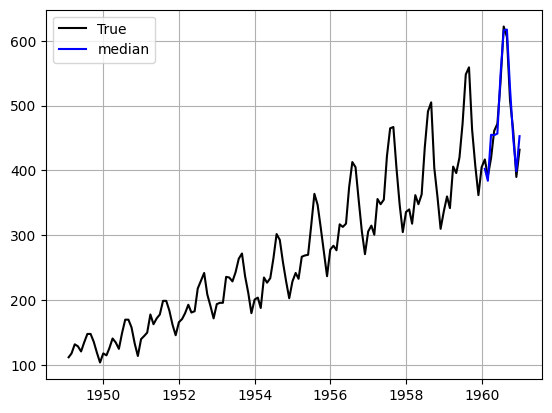

In [ ]:
#| eval: false
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.models import NHITS
from neuralforecast.losses.pytorch import DistributionLoss, HuberLoss, MAE
from neuralforecast.tsdataset import TimeSeriesDataset
from neuralforecast.utils import AirPassengers, AirPassengersPanel, AirPassengersStatic

#AirPassengersPanel['y'] = 1 * (AirPassengersPanel['trend'] % 12) < 2
Y_train_df = AirPassengersPanel[AirPassengersPanel.ds<AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 132 train
Y_test_df = AirPassengersPanel[AirPassengersPanel.ds>=AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 12 test

model = NHITS(h=12,
              input_size=24,
              #loss=DistributionLoss(distribution='StudentT', level=[80, 90], return_params=True),
              loss=HuberLoss(delta=0.5),
              valid_loss=MAE(),
              stat_exog_list=['airline1'],
              scaler_type='robust',
              max_steps=200,
              early_stop_patience_steps=2,
              val_check_steps=10,
              learning_rate=1e-3)

fcst = NeuralForecast(models=[model], freq='M')
fcst.fit(df=Y_train_df, static_df=AirPassengersStatic, val_size=12)
forecasts = fcst.predict(futr_df=Y_test_df)

# Plot quantile predictions
Y_hat_df = forecasts.reset_index(drop=False).drop(columns=['unique_id','ds'])
plot_df = pd.concat([Y_test_df, Y_hat_df], axis=1)
plot_df = pd.concat([Y_train_df, plot_df])

plot_df = plot_df[plot_df.unique_id=='Airline1'].drop('unique_id', axis=1)
plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
plt.plot(plot_df['ds'], plot_df['NHITS'], c='blue', label='median')
# plt.plot(plot_df['ds'], plot_df['NHITS-median'], c='blue', label='median')
# plt.fill_between(x=plot_df['ds'][-12:],
#                  y1=plot_df['NHITS-lo-90'][-12:].values,
#                  y2=plot_df['NHITS-hi-90'][-12:].values,
#                  alpha=0.4, label='level 90')
plt.legend()
plt.grid()
plt.plot()

In [ ]:
y_true = Y_test_df.y.values
y_hat = Y_hat_df['NHITS'].values


In [ ]:
from neuralforecast.losses.numpy import mae, mse

print('MAE: ', mae(y_hat, y_true))
print('MSE: ', mse(y_hat, y_true))

MAE:  14.198963165283203
MSE:  270.21525646672427
